In [1]:
#This is the notebook to set and train the clusterer
#Save in:
PATH_OUT = 'assets/'

In [2]:
from datamanager.DM_Belgique import DM_Belgique
from datamanager.DM_USA import DM_USA

In [3]:
import pandas as pd
import numpy as np
import time
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
import pickle

In [4]:
data_manager = DM_USA()
#path = '/Users/augustecousin/Documents/bel_gm_tool/gm_tool/data/220207_Belgium_Dataset.csv'
data_manager.open_excel()
data_manager.df.rename(columns={'ACV': 'Distribution'}, inplace=True)

page 1 / 13
page 2 / 13
page 3 / 13
page 4 / 13
page 5 / 13
page 6 / 13
page 7 / 13
page 8 / 13
page 9 / 13
page 10 / 13
page 11 / 13
page 12 / 13
page 13 / 13


In [5]:
df_kproto = data_manager.df[["Category", "Sub Category", "Brand", "Distribution", "Price per volume", "Sales in volume"]]
print(df_kproto.shape)

(563326, 6)


In [6]:
count_df = data_manager.df.fillna(0.0).groupby(['Category', 'Sub Category', 'Brand'], as_index=False).count()
count_df = count_df[count_df.Period==209][['Category', 'Sub Category', 'Brand']]
df_kproto = pd.merge(count_df, df_kproto, on=['Category', 'Sub Category', 'Brand'])

In [7]:
df_kproto.shape

(328548, 6)

In [8]:
df_brand_categ = df_kproto.groupby(['Brand'])['Category'].agg(Number_of_Categories = "nunique").reset_index().rename(columns={'Number_of_Categories':'Number of Categories'})
df_kproto = pd.merge(df_kproto, df_brand_categ, on="Brand", how="left")


df_sub_cat = df_kproto.groupby(['Brand', 'Category'])['Sub Category'].agg(Sub_Categories='nunique').reset_index().rename(columns={'Sub_Categories':'Number of Sub Categories'})
df_kproto = pd.merge(df_kproto, df_sub_cat, on=["Brand", 'Category'], how="left")


In [9]:
df_kproto

,Category,Sub Category,Brand,Distribution,Price per volume,Sales in volume,Number of Categories,Number of Sub Categories
0,CLASSIC SPREADS,ALL SUB CATEGORIES,ALL BRANDS,575.830251,6.64508,556275.267445,13,1
1,CLASSIC SPREADS,ALL SUB CATEGORIES,ALL BRANDS,529.121482,6.777484,390836.08558,13,1
2,CLASSIC SPREADS,ALL SUB CATEGORIES,ALL BRANDS,505.467804,6.62401,359135.012619,13,1
3,CLASSIC SPREADS,ALL SUB CATEGORIES,ALL BRANDS,502.068132,6.727514,344617.692733,13,1
4,CLASSIC SPREADS,ALL SUB CATEGORIES,ALL BRANDS,499.754517,6.707119,337336.433983,13,1
...,...,...,...,...,...,...,...,...
328543,SNACKING COMBOS,CHEESE SNACKING COMBO,SARGENTO,747.188439,12.546725,327775.875738,5,2
328544,SNACKING COMBOS,CHEESE SNACKING COMBO,SARGENTO,780.558632,12.509067,436998.865223,5,2
328545,SNACKING COMBOS,CHEESE SNACKING COMBO,SARGENTO,771.927408,12.441168,437174.618794,5,2
328546,SNACKING COMBOS,CHEESE SNACKING COMBO,SARGENTO,770.95922,12.429005,395978.659122,5,2


In [10]:
NUMBER_OF_PERIODS = 209

In [11]:
"""remove brand histories with more than 3 0.0 in their ACV"""
l_to_remove=[]
count=0
for filters, group in df_kproto.groupby(['Category', 'Sub Category', 'Brand']):
    if np.count_nonzero(group['Distribution']) < (NUMBER_OF_PERIODS-3):
        l_to_remove.append(group.index.values)
l_to_remove = np.array(l_to_remove).flatten()

df_kproto=df_kproto[~df_kproto.index.isin(l_to_remove)].reset_index(drop=True)

In [12]:
df_kproto['Distribution'] = np.array(map(np.log1p, df_kproto['Distribution'].values))
df_kproto['Price per volume'] = np.array(map(np.log1p, df_kproto['Price per volume'].values))

In [13]:
#df_kproto['Distribution'] = df_kproto['Distribution'].apply(np.log1p)


In [14]:
df_sub = df_kproto.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Number of Categories', 'Number of Sub Categories'].max()

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_42330/4005983464.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sub = df_kproto.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Number of Categories', 'Number of Sub Categories'].max()


In [15]:
"""compute high level metrics for time series of Distribution and Price per volume : min, max, mean, std"""
Distribution = df_kproto.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Distribution'].agg(
    {'min Distribution':'min', 'max Distribution':'max', 'mean Distribution':'mean', 'std Distribution':'std'}
)

Price = df_kproto.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Price per volume'].agg(
    {'min Price':'min', 'max Price':'max', 'mean Price':'mean', 'std Price':'std'}
)

In [16]:
"""merge high level metrics into df_sub"""
df_sub = pd.merge(df_sub, Distribution, on=['Category', 'Sub Category', 'Brand'])

df_sub = pd.merge(df_sub, Price, on=['Category', 'Sub Category', 'Brand'])

In [17]:
df_sub = df_sub.fillna(0.0)

In [18]:
"""elbow method for number of clusters"""
cost = []
K = range(2, 16)
for num_clusters in list(K):
    start = time.time()
    model = KPrototypes(n_clusters=num_clusters, init="Cao", n_init=1, max_iter=50, random_state=0)
    model.fit_predict(df_sub, 
                      categorical=[df_sub.columns.get_loc(column) for column in ["Category", "Sub Category", "Brand"]])
    end = time.time()
    cost.append(model.cost_)
    print("Number of clusters:", num_clusters, " | Runtime (s):", round(end-start, 2), " | Cost:", round(model.cost_, 2))

Number of clusters: 2  | Runtime (s): 0.48  | Cost: 18292.45
Number of clusters: 3  | Runtime (s): 0.61  | Cost: 14359.84
Number of clusters: 4  | Runtime (s): 0.68  | Cost: 10870.63
Number of clusters: 5  | Runtime (s): 1.29  | Cost: 9721.01
Number of clusters: 6  | Runtime (s): 1.39  | Cost: 8699.67
Number of clusters: 7  | Runtime (s): 1.2  | Cost: 8186.16
Number of clusters: 8  | Runtime (s): 1.05  | Cost: 7847.2
Number of clusters: 9  | Runtime (s): 1.62  | Cost: 7529.71
Number of clusters: 10  | Runtime (s): 1.65  | Cost: 7207.4
Number of clusters: 11  | Runtime (s): 1.33  | Cost: 6964.3
Number of clusters: 12  | Runtime (s): 1.56  | Cost: 6794.95
Number of clusters: 13  | Runtime (s): 1.18  | Cost: 6582.85
Number of clusters: 14  | Runtime (s): 2.17  | Cost: 6373.42
Number of clusters: 15  | Runtime (s): 2.43  | Cost: 6054.14


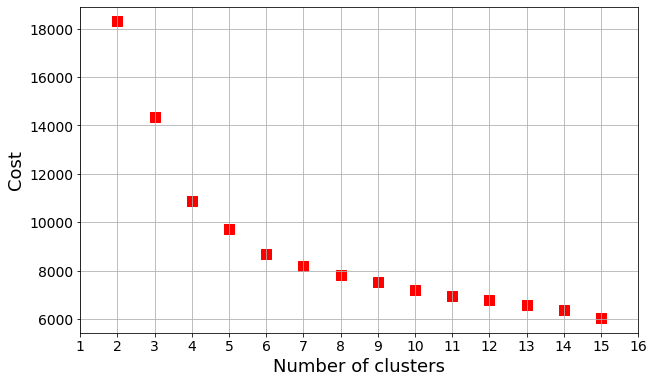

In [19]:
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams.update({'font.size': 14})
plt.scatter(x=K, y=cost,
            marker="s", s=100, color="red")
plt.xlabel("Number of clusters", fontsize=18)
plt.ylabel("Cost", fontsize=18)
plt.xticks(range(1, 17, 1))
plt.grid()
plt.show()

In [20]:
"""create and train clustering algorithm with n clusters"""
n_clusters=5
model = KPrototypes(n_clusters=n_clusters, init="Cao", max_iter=50, random_state=0)
model.fit(df_sub.values,
          categorical=[df_sub.columns.get_loc(column) for column in ["Category", "Sub Category", "Brand"]])

KPrototypes(gamma=0.7864608262805831, max_iter=50, n_clusters=5, random_state=0)

In [21]:
"""save model as clusterer_Belgium.sav"""
#pickle.dump(model, open(PATH_OUT + 'clusterer_Belgium.sav', 'wb'))

'save model as clusterer_Belgium.sav'

In [22]:
#data_manager.df[data_manager.df.Category=='SNACKING COMBOS'][data_manager.df['Sub Category']=='CHEESE SNACKING COMBO'][data_manager.df['Brand']=='THE LAUGHING COW']

In [23]:
#data_manager.df

In [24]:
"""store clusters and profiles"""
df_sub["Cluster"] = model.labels_

dict_clusters_sales = dict()
dict_all_sales = {x:{} for x in range(n_clusters)}
#TODO: with groupby is better
for index, row in df_sub.iterrows():
    sales = df_kproto[df_kproto['Category']==row['Category']]\
                     [df_kproto['Sub Category']==row['Sub Category']]\
                     [df_kproto['Brand']==row['Brand']]["Sales in volume"].values
    #print(sales.shape)
    
    dict_all_sales[row["Cluster"]][row["Brand"]+row["Category"]+row["Sub Category"]] = sales
    
    
    if row["Cluster"] not in dict_clusters_sales:
        dict_clusters_sales[row["Cluster"]] = sales
    else:
        dict_clusters_sales[row["Cluster"]] += sales
    
for i in range(0, n_clusters):
    dict_clusters_sales[i] = dict_clusters_sales[i] / df_sub["Cluster"].value_counts().sort_index().values[i]

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_42330/3685112929.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sales = df_kproto[df_kproto['Category']==row['Category']]\


(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)
(209,)

In [25]:
"""save clusters and profiles"""
profiles = pd.DataFrame(dict_clusters_sales)
#profiles.to_csv(PATH_OUT+'profiles_USA.csv', index=False)

clusters = df_sub[['Category', 'Sub Category', 'Brand', 'Cluster']]
#clusters.to_csv(PATH_OUT+'clusters_USA.csv', index=False)

In [33]:
profiles.columns

Int64Index([4, 3, 1, 0, 2], dtype='int64')

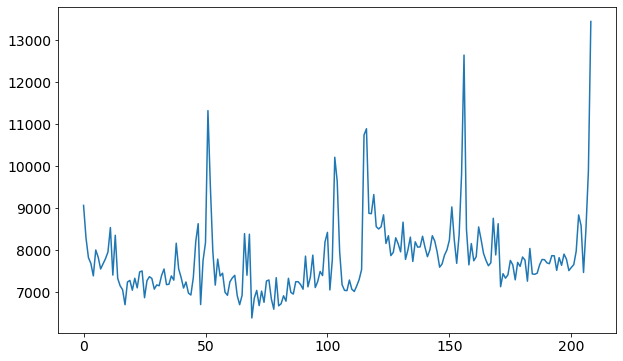

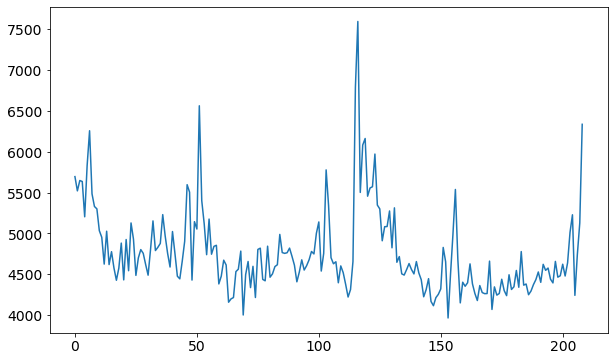

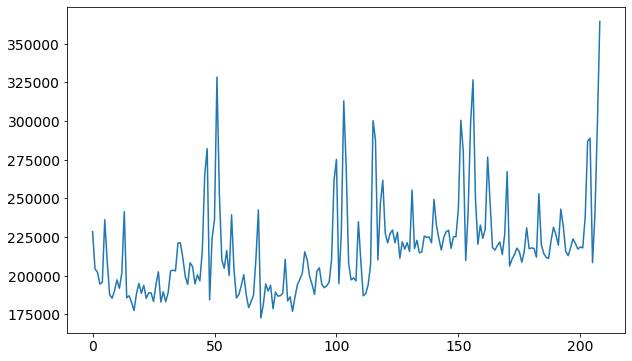

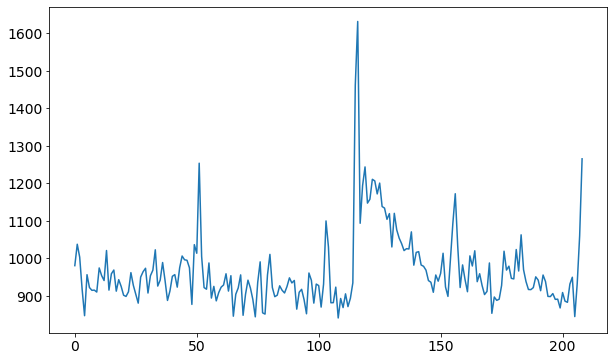

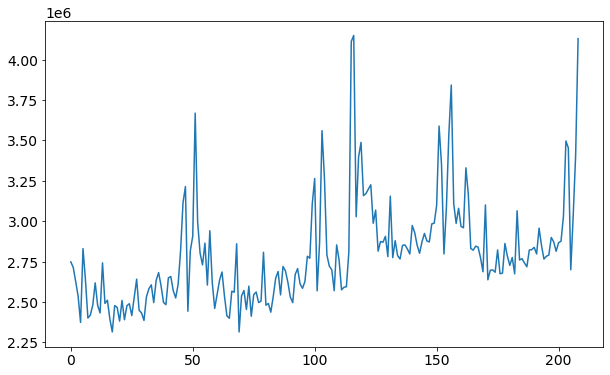

In [34]:
profiles[0].plot()
plt.show()
profiles[1].plot()
plt.show()
profiles[2].plot()
plt.show()
profiles[3].plot()
plt.show()
profiles[4].plot()
plt.show()